# Start building my model
is what features can predict pace for a run?
2) i want to know based on my training, what can i run in a 5k, 10k, half marathon, and marathon right now. 
    - i see this going in a few ways, so how well can i forecase my next week of running?
    - what features do i need to create 

In [1]:
import warnings
warnings.filterwarnings('ignore')

# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Scikit-learn model selection & evaluation
from sklearn.model_selection import (
    train_test_split, KFold, GridSearchCV, 
    cross_val_score, cross_val_predict, validation_curve
)
from sklearn.metrics import (
    mean_squared_error, r2_score, mean_absolute_error, make_scorer
)

# Scikit-learn models and pipelines
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder


In [2]:

print(f"pandas: {pd.__version__}")
print(f"numpy: {np.__version__}")
print(f"seaborn: {sns.__version__}")
import sklearn
print(f"scikit-learn: {sklearn.__version__}")

pandas: 2.3.0
numpy: 2.3.0
seaborn: 0.13.2
scikit-learn: 1.7.0


In [3]:
# loading in the cleaned data
run_data_clean= pd.read_csv("/Users/Nicole/strava_running/personal_running_data/activities_cleaned.csv")

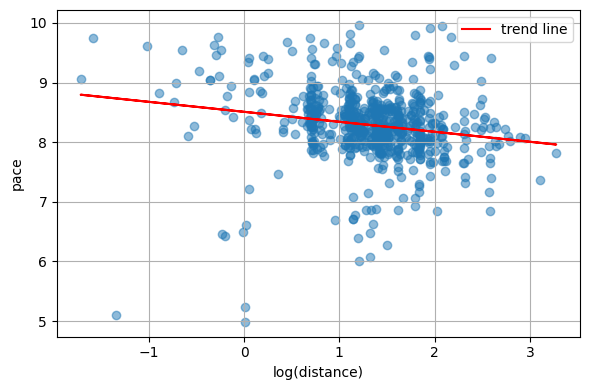

In [4]:
# i'm actually going to log my distance data because i have many more shorter runs than i do longer runs.
# my data is also skewed where i have more short runs than longer runs, so logging will help with that
# i will look into other transofrmations but this will work right now

run_data_clean['log_distance'] = np.log(run_data_clean['distance_miles'])

#old plot to show kind of a flat relationship between distance and mpace
#plt.scatter(run_data_clean['distance_miles'], run_data_clean['pace'], alpha=0.5)
#plt.grid(True)
#plt.xlabel("distance")
#plt.ylabel("pace")
#plt.title("distance vs pace")
#plot.show()

slope, intercept = np.polyfit(run_data_clean['log_distance'], run_data_clean['pace'], 1)
trend_line = slope * run_data_clean['log_distance'] + intercept

#plotting
plt.figure(figsize=(6, 4))
plt.scatter(run_data_clean['log_distance'], run_data_clean['pace'], alpha=0.5)
plt.plot(run_data_clean['log_distance'], trend_line, color='red', label = 'trend line')
plt.grid(True)
plt.xlabel("log(distance)")
plt.ylabel("pace")
plt.legend()
plt.tight_layout()

In [5]:
# removing time_minutes, calories, and elevation_low from features since they are super correlated
# these i think are some of the important features that can predict pace. 
features = ['average_cadence', 'max_cadence', 'average_heart_rate',
            'max_heart_rate', 'max_speed_mph', 'log_distance',
            'elevation_gain', 'elevation_loss', 'elevation_high', 'relative_effort']

# Input and target
X = run_data_clean[features]
y = run_data_clean['pace']

# doing the grid search and cross validation 
mse_scorer = 'neg_mean_squared_error'
cv = 5

results = {}

# --- Lasso Regression ---
lasso_pipe = Pipeline([
    ("lasso", Lasso(random_state=42))
])

lasso_params = {
    'lasso__alpha': np.array([
        5.e-3, 7.e-3, 9.e-3, 1.e-2, 3.e-2, 5.e-2, 7.e-2, 9.e-2,
        0.1, 0.3, 0.5, 0.7, 0.9, 1.0]),
    'lasso__max_iter': [2000]
}

lasso_grid = GridSearchCV(lasso_pipe, lasso_params, scoring=mse_scorer, cv=cv)
lasso_grid.fit(X, y)

results['Lasso'] = {
    'model': lasso_grid,
    'best_score': -lasso_grid.best_score_,
    'best_params': lasso_grid.best_params_
}


print(f"best lasso MSE: {-lasso_grid.best_score_:.3f} | best alpha: {lasso_grid.best_params_['lasso__alpha']}")
print(f"best params: {lasso_grid.best_params_}")

# --- Ridge Regression ---
ridge_pipe = Pipeline([
    ("ridge", Ridge())
])

ridge_params = {
    "ridge__alpha": np.array([
        5.e-3, 7.e-3, 9.e-3, 1.e-2, 3.e-2, 5.e-2, 7.e-2, 9.e-2,
        0.1, 0.3, 0.5, 0.7, 0.9, 1.0]),
    'ridge__max_iter': [2000]
}

ridge_grid = GridSearchCV(ridge_pipe, ridge_params, scoring=mse_scorer, cv=cv)
ridge_grid.fit(X, y)

results['Ridge'] = {
    'model': ridge_grid,
    'best_score': -ridge_grid.best_score_,
    'best_params': ridge_grid.best_params_
}

print(f"ridge best MSE: {-ridge_grid.best_score_:.3f} | best alpha: {ridge_grid.best_params_['ridge__alpha']}")
print(f"best params: {ridge_grid.best_params_}")

# --- Random Forest ---
rf_pipe = Pipeline([
    ("rf", RandomForestRegressor(random_state=42))
])

rf_params = {
    "rf__n_estimators": [50, 100, 200],
    "rf__max_depth": [None, 10, 20],
    "rf__min_samples_split": [2, 5]
}

rf_grid = GridSearchCV(rf_pipe, rf_params, scoring=mse_scorer, cv=cv)
rf_grid.fit(X, y)

results['Random Forest'] = {
    'model': rf_grid,
    'best_score': -rf_grid.best_score_,
    'best_params': rf_grid.best_params_
}


print(f"rf best MSE: {-rf_grid.best_score_:.3f}")
print(f"best params: {rf_grid.best_params_}")


best lasso MSE: 0.180 | best alpha: 0.007
best params: {'lasso__alpha': np.float64(0.007), 'lasso__max_iter': 2000}
ridge best MSE: 0.181 | best alpha: 1.0
best params: {'ridge__alpha': np.float64(1.0), 'ridge__max_iter': 2000}
rf best MSE: 0.192
best params: {'rf__max_depth': 10, 'rf__min_samples_split': 5, 'rf__n_estimators': 100}


In [6]:
# using the grid search going to plot the output using the best models
best_models = {
    'Lasso': lasso_grid.best_estimator_,
    'Ridge': ridge_grid.best_estimator_, 
    'Random Forest': rf_grid.best_estimator_
}

# stored grid search
grid_results = {
    'Lasso': {'mse': -lasso_grid.best_score_, 'params': lasso_grid.best_params_},
    'Ridge': {'mse': -ridge_grid.best_score_, 'params': ridge_grid.best_params_},
    'Random Forest': {'mse': -rf_grid.best_score_, 'params': rf_grid.best_params_}
}

# Create comprehensive visualization
##fig = plt.figure(figsize=(20, 15))

# need to do the cross val to get the data to plot
kf = KFold(n_splits=5, shuffle=True, random_state=41)
cv_results = []

for name, model in best_models.items():
    scores = cross_val_score(model, X, y, cv=kf, scoring=mse_scorer)
    positive_mse = -scores
    cv_results.append(pd.DataFrame({
        'Model': name,
        'Fold': np.arange(1, len(scores)+1),
        'MSE': positive_mse
    }))

cv_results_df = pd.concat(cv_results)


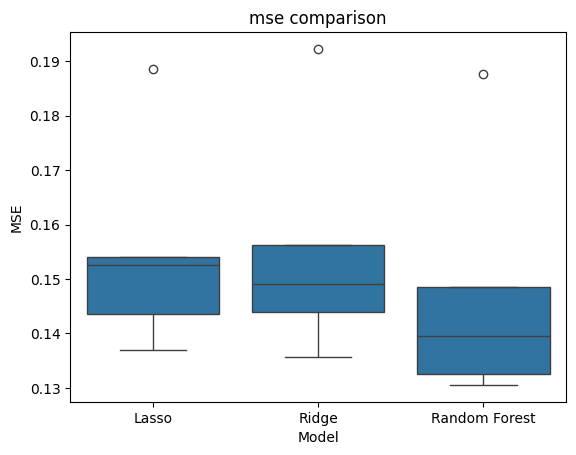

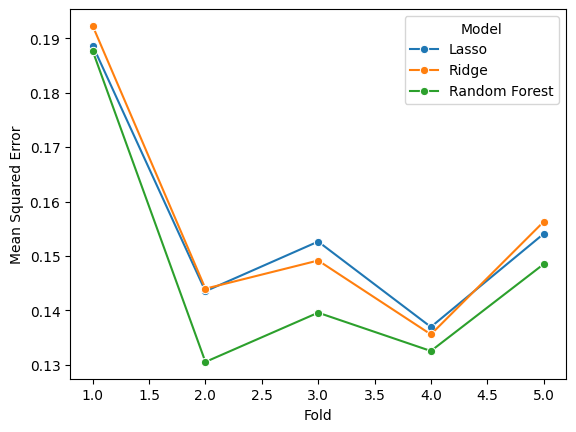

In [7]:
# box plot
#ax1 = plt.subplot(3, 4, 1)
sns.boxplot(x='Model', y='MSE', data=cv_results_df)
plt.title('mse comparison')
plt.show()
# Lineplot showing MSE per fold for each model
sns.lineplot(x='Fold', y='MSE', hue='Model', marker='o', data=cv_results_df)
plt.ylabel('Mean Squared Error')
plt.show()

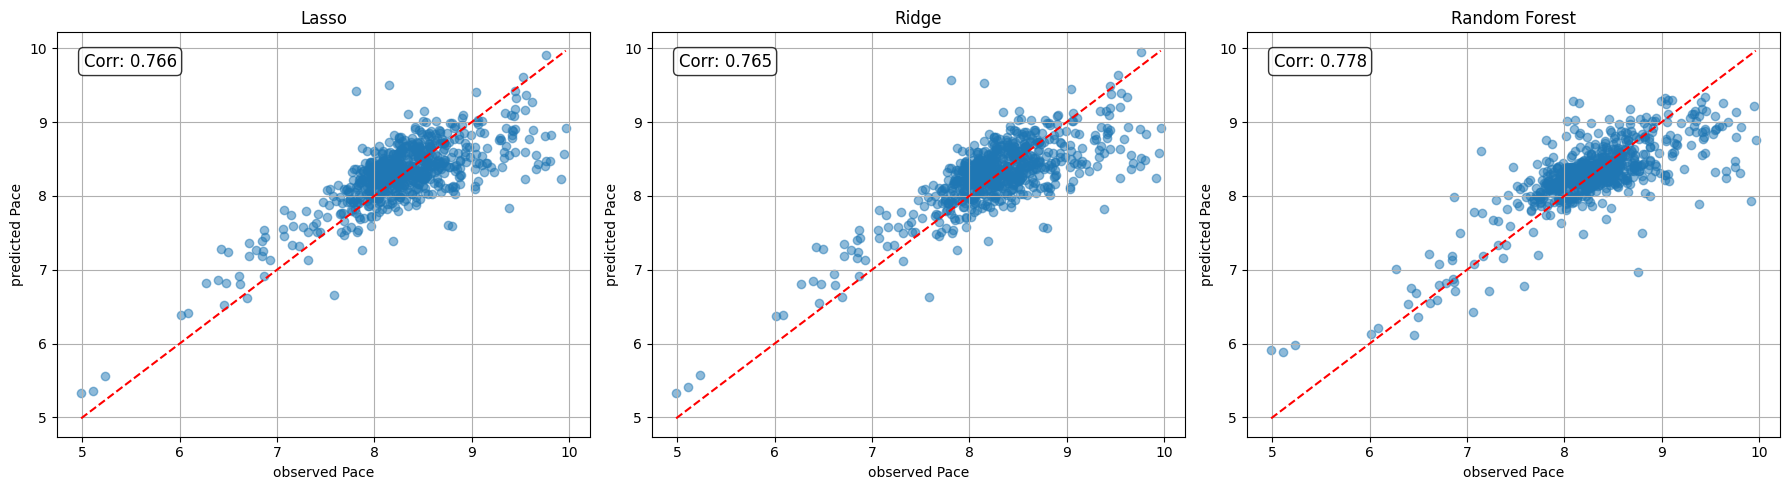

In [8]:
plt.figure(figsize=(18, 5))

for i, (name, model) in enumerate(best_models.items(), 1):
    y_pred = cross_val_predict(model, X, y, cv=kf)
    
    # pearson correlatoin
    corr, _ = stats.pearsonr(y, y_pred)
    
    plt.subplot(1, 3, i)
    plt.scatter(y, y_pred, alpha=0.5)
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')  # perfect prediction line
    plt.xlabel('observed Pace')
    plt.ylabel('predicted Pace')
    plt.title(f'{name}')
    plt.grid(True)
    
    # adding in the stats
    plt.text(
        0.05, 0.95, f'Corr: {corr:.3f}', 
        transform=plt.gca().transAxes, 
        fontsize=12,
        verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
    )

plt.tight_layout()
plt.show()

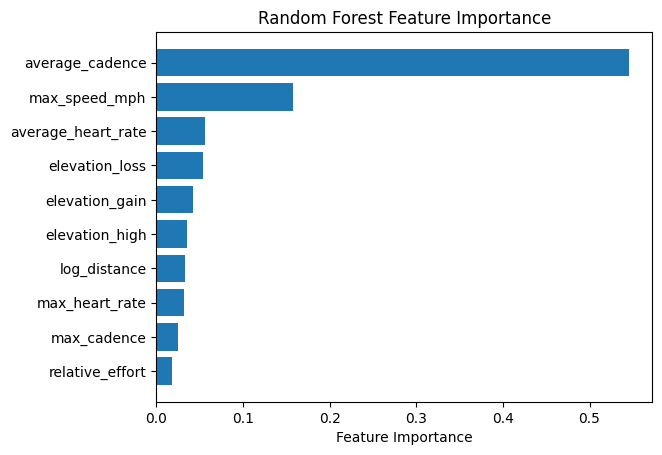

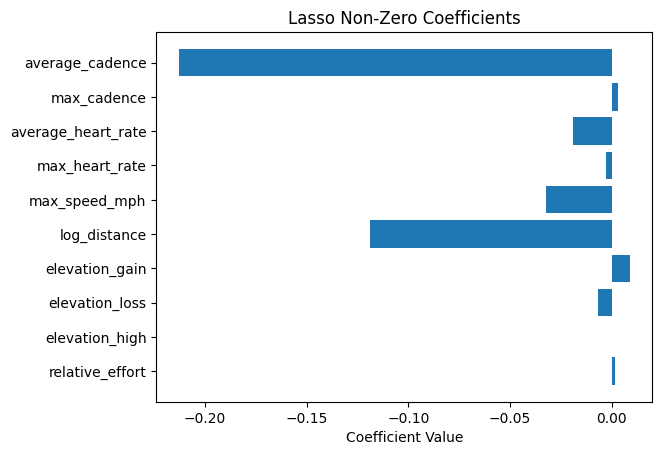

In [9]:
# showing rf feature importance 

rf_model = best_models['Random Forest']
rf_model.fit(X, y)  # Fit on full data for feature importance

feature_importance = rf_model.named_steps['rf'].feature_importances_
feature_names = X.columns

# Sort features by importance
indices = np.argsort(feature_importance)[::-1]

plt.barh(range(len(feature_importance)), feature_importance[indices])
plt.yticks(range(len(feature_importance)), [feature_names[i] for i in indices])
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance')
plt.gca().invert_yaxis()
plt.show()

# show lasso feature importance
lasso_model = best_models['Lasso']
lasso_model.fit(X, y)

coefficients = lasso_model.named_steps['lasso'].coef_
feature_names = X.columns

# Only show non-zero coefficients
non_zero_idx = coefficients != 0
if non_zero_idx.any():
    plt.barh(range(sum(non_zero_idx)), coefficients[non_zero_idx])
    plt.yticks(range(sum(non_zero_idx)), feature_names[non_zero_idx])
    plt.xlabel('Coefficient Value')
    plt.title('Lasso Non-Zero Coefficients')
    plt.gca().invert_yaxis()
    plt.show()

# prediction
my watch says my marathon prediction is 1;34 and 3:35, lets see what this model says

In [10]:
# now i am going to predict my marathon and half marathon

# Prepare race in puts 
race_inputs = {
        'HalfMarathon': pd.DataFrame([{
        'average_cadence': 95,      # Slightly lower than 5K
        'max_cadence': 97,
        'average_heart_rate': 183,  # Moderate for 10K distance
        'max_heart_rate': 210,
        'max_speed_mph': 14.0,      # Moderate speed for 10K
        'log_distance': np.log(13.1),  
        'elevation_gain': 100,       # Moderate elevation
        'elevation_loss': 100,
        'elevation_high': 250,
        'relative_effort': 350      # Moderate effort for 10K
    }]),
    
    'Marathon': pd.DataFrame([{
      'average_cadence': 92,
        'max_cadence': 95,
        'average_heart_rate': 183,
        'max_heart_rate': 210,
        'max_speed_mph': 12.0,
        'log_distance': np.log(26.2),
        'elevation_gain': 100,
        'elevation_loss': 100,
        'elevation_high': 250,
        'relative_effort': 700    # High total effort for marathon
    }])
}


In [11]:
# now i am going to predict my marathon, half marathon,Z

# best random forest model
rf_best_model = results['Random Forest']['model'].best_estimator_

# Make prediction
predicted_pace = rf_best_model.predict(race_inputs['Marathon'])[0]

print(f"\nPredicted Marathon Pace: {predicted_pace:.2f} minutes per mile")

# Convert to total marathon time
total_time_minutes = predicted_pace * 26.2
hours = int(total_time_minutes // 60)
minutes = int(total_time_minutes % 60)
seconds = int((total_time_minutes % 1) * 60)

print(f"Predicted Marathon Time: {hours}:{minutes:02d}:{seconds:02d}")

# Get individual tree predictions for confidence estimation
if hasattr(rf_best_model.named_steps['rf'], 'estimators_'):
    tree_predictions = []
    for tree in rf_best_model.named_steps['rf'].estimators_:
        tree_pred = tree.predict(race_inputs['Marathon'])[0]
        tree_predictions.append(tree_pred)
    
    tree_predictions = np.array(tree_predictions)
    pred_std = np.std(tree_predictions)
    pred_mean = np.mean(tree_predictions)
    
    print(f"Prediction Mean: {pred_mean:.3f} min/mile")
    print(f"Prediction Std:  {pred_std:.3f} min/mile")
    print(f"95% Confidence Interval: [{pred_mean - 1.96*pred_std:.3f}, {pred_mean + 1.96*pred_std:.3f}] min/mile")
    
    # Convert CI to time format
    ci_low_time = (pred_mean - 1.96*pred_std) * 26.2
    ci_high_time = (pred_mean + 1.96*pred_std) * 26.2
    
    ci_low_hrs = int(ci_low_time // 60)
    ci_low_mins = int(ci_low_time % 60)
    ci_low_secs = int((ci_low_time % 1) * 60)
    
    ci_high_hrs = int(ci_high_time // 60)
    ci_high_mins = int(ci_high_time % 60)
    ci_high_secs = int((ci_high_time % 1) * 60)
    
    print(f"95% Time Interval: {ci_low_hrs}:{ci_low_mins:02d}:{ci_low_secs:02d} - {ci_high_hrs}:{ci_high_mins:02d}:{ci_high_secs:02d}")


Predicted Marathon Pace: 7.85 minutes per mile
Predicted Marathon Time: 3:25:45
Prediction Mean: 7.854 min/mile
Prediction Std:  0.385 min/mile
95% Confidence Interval: [7.098, 8.609] min/mile
95% Time Interval: 3:05:58 - 3:45:33


In [12]:
# now i am going to predict half marathon time

# best random forest model
rf_best_model = results['Random Forest']['model'].best_estimator_

# Make prediction
predicted_pace = rf_best_model.predict(race_inputs['HalfMarathon'])[0]

print(f"\nPredicted Half Marathon Pace: {predicted_pace:.2f} minutes per mile")

# Convert to total marathon time
total_time_minutes = predicted_pace * 13.1
hours = int(total_time_minutes // 60)
minutes = int(total_time_minutes % 60)
seconds = int((total_time_minutes % 1) * 60)

print(f"Predicted Half Marathon Time: {hours}:{minutes:02d}:{seconds:02d}")

# Get individual tree predictions for confidence estimation
if hasattr(rf_best_model.named_steps['rf'], 'estimators_'):
    tree_predictions = []
    for tree in rf_best_model.named_steps['rf'].estimators_:
        tree_pred = tree.predict(race_inputs['Marathon'])[0]
        tree_predictions.append(tree_pred)
    
    tree_predictions = np.array(tree_predictions)
    pred_std = np.std(tree_predictions)
    pred_mean = np.mean(tree_predictions)
    
    print(f"Prediction Mean: {pred_mean:.3f} min/mile")
    print(f"Prediction Std:  {pred_std:.3f} min/mile")
    print(f"95% Confidence Interval: [{pred_mean - 1.96*pred_std:.3f}, {pred_mean + 1.96*pred_std:.3f}] min/mile")
    
    # Convert CI to time format
    ci_low_time = (pred_mean - 1.96*pred_std) * 13.1
    ci_high_time = (pred_mean + 1.96*pred_std) * 13.1
    
    ci_low_hrs = int(ci_low_time // 60)
    ci_low_mins = int(ci_low_time % 60)
    ci_low_secs = int((ci_low_time % 1) * 60)
    
    ci_high_hrs = int(ci_high_time // 60)
    ci_high_mins = int(ci_high_time % 60)
    ci_high_secs = int((ci_high_time % 1) * 60)
    
    print(f"95% Time Interval: {ci_low_hrs}:{ci_low_mins:02d}:{ci_low_secs:02d} - {ci_high_hrs}:{ci_high_mins:02d}:{ci_high_secs:02d}")


Predicted Half Marathon Pace: 7.17 minutes per mile
Predicted Half Marathon Time: 1:33:55
Prediction Mean: 7.854 min/mile
Prediction Std:  0.385 min/mile
95% Confidence Interval: [7.098, 8.609] min/mile
95% Time Interval: 1:32:59 - 1:52:46


# Next steps

1) my previous model treats all data as the same but really its the most recent running that should give more weight that my running from 2021. i want to update it with putting a weight in place
2) i also think it could be really cool to get my friends running data and cluster their data with mine to see how their data can help with mine. i think strava actually clusters poeple together and then uses the data of who you train like to make predictions about your times

In [ ]:
# i also want to weight my most recent training the last 12 weeks because that will give more weight to what i can run right now
# i'm going to try an exponential decay and a piecewise decay

weeks = np.arange(0, 100)
for alpha in [0.5, 0.7, 0.85, 0.9, 0.95, 0.98]:
    weights = alpha ** weeks
    plt.plot(weeks, weights, label=f'α = {alpha}')

plt.title("Exponential Decay Weights")
plt.xlabel("Weeks Ago")
plt.ylabel("Weight")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# applying the weight
run_data_clean['activity_date'] = pd.to_datetime(run_data_clean['activity_date'])

run_data_clean['weeks_ago'] = (run_data_clean['activity_date'].max() - run_data_clean['activity_date']).dt.days / 7

# exponential decay weight
alpha = 0.95  
run_data_clean['weight'] = alpha ** run_data_clean['weeks_ago']